In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install wandb

# Importing dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb
wandb.init(project="mnist-gans", name="acgan")

# Data Loading

## Download and normalize to range [-1, 1]

In [ ]:
dataset_train = torchvision.datasets.FashionMNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataset_test = torchvision.datasets.FashionMNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw
Processing...
Done!


## Concatenating train and test dataset

In [ ]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [ ]:
torch.cuda.is_available()

True

In [ ]:
params = {}
params['epochs'] = 20
params['output_after_every_n_epochs'] = 1
params['image_size'] = 28
params['noise_size'] = 100
params['batch_size'] = 64
params['num_channels'] = 1
params['num_classes'] = len(dataset_train.classes)
params['seed'] = 0
wandb.config.update(params)

In [ ]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Note: PyTorch does not guarantee reproducability
# Taken from https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(params['seed'])

## Convert into DataLoader

In [ ]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)

In [ ]:
dataiter = iter(datasetloader)

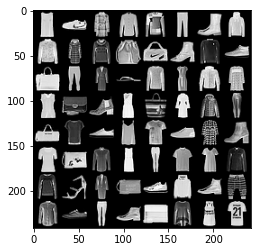

In [ ]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [ ]:
def initialize_weights(model):
  className = model.__class__.__name__
  if className.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif className.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [ ]:
class Generator(nn.Module):
  '''
  The generator network
  '''
  def __init__(self, input_size, num_channels, num_classes):
    super(Generator, self).__init__()

    # For labels
    self.label_embedding = nn.Embedding(num_classes, input_size)
    self.linear = nn.Sequential(nn.Linear(input_size, 128 * 4 ** 2))
    # 4 ** 2 will come handy as we reshape the layer to (batch_size, 128, 4, 4)
    # as the first Transposed Conv layer is skipped.

    self.norm_layer = nn.Sequential(
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    # Shape [4 x 4]

    self.conv_trans_1 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 1, 0, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )
    # Shape [7 x 7]

    self.conv_trans_2 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
    )
    # Shape [14 x 14]

    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(32, num_channels, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    # Shape [28 x 28]
        

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs, labels):
    x = torch.mul(self.label_embedding(labels), inputs)
    x = self.linear(x)
    x = x.view(x.shape[0], 128, 4, 4)
    x = self.norm_layer(x)
    x = self.conv_trans_1(x)
    x = self.conv_trans_2(x)
    return self.output_layer(x)

In [ ]:
generator = Generator(params['noise_size'], params['num_channels'], params['num_classes'])
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (label_embedding): Embedding(10, 100)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (norm_layer): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (conv_trans_1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (output_layer): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


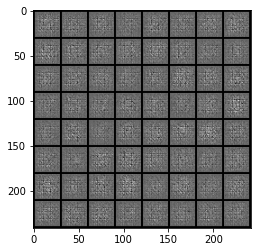

Generator(
  (label_embedding): Embedding(10, 100)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (norm_layer): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (conv_trans_1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (output_layer): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

In [ ]:
with torch.no_grad():
  generator.eval()
  _, labels = dataiter.next()
  noise = torch.randn(size=(params['batch_size'], params['noise_size'])).cuda()
  output = generator(noise, labels.cuda()).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [ ]:
class Discriminator(nn.Module):
  '''
  The Discriminator Network
  '''
  def __init__(self, num_channels, num_classes):
    super(Discriminator, self).__init__()

    self.conv_1 = nn.Sequential(
        nn.Conv2d(num_channels, 16, 3, 2, 1),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.2)
    )
    # Shape [14 x 14]

    self.conv_2 = nn.Sequential(
        nn.Conv2d(16, 32, 3, 2, 1),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32, 0.8)
    )
    # Shape [7 x 7]

    self.conv_3 = nn.Sequential(
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(0.2, inplace = True),
        nn.BatchNorm2d(64, 0.8)
    )
    # Shape [4 x 4]

    # Discriminator Layer
    self.discrim = nn.Sequential(
        nn.Linear(64 * 4 ** 2, 1),
        nn.Sigmoid()
    )

    # Auxillary Layer
    self.aux = nn.Sequential(
        nn.Linear(64 * 4 ** 2, num_classes),
        nn.Softmax(dim=1)
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.conv_3(x)
    input_ = x.view(x.size(0), -1)
    labels = self.aux(input_)
    valid = self.discrim(input_)
    return valid, labels

In [ ]:
discriminator = Discriminator(params['num_channels'], params['num_classes'])
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (discrim): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (aux): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

# Specifying Loss Function

In [ ]:
adversarial_loss = nn.BCELoss().cuda()
auxillary_loss = nn.CrossEntropyLoss().cuda()

# Plotting output after each epoch

In [ ]:
# Fixed input noise
fixed_noise = torch.randn(size=(params['num_classes'], params['noise_size'])).cuda()
fixed_labels = torch.tensor([i for i in range(10)]).cuda()

def plot_output(epoch):
    plt.clf()
    with torch.no_grad():
    
        generator.eval()
        test_images = generator(fixed_noise, fixed_labels)
        generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True, nrow=5)
    show_grid(grid)
    wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

  

# Training

Epoch: 1 / 20
Discriminator Total Loss: 2.350, Discriminator Accuracy: 0.807, Generator Total Loss: 1.156


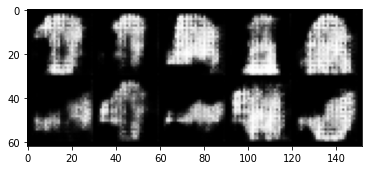

Epoch: 2 / 20
Discriminator Total Loss: 2.267, Discriminator Accuracy: 0.871, Generator Total Loss: 1.109


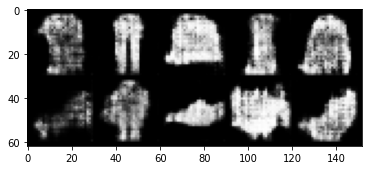

Epoch: 3 / 20
Discriminator Total Loss: 2.265, Discriminator Accuracy: 0.886, Generator Total Loss: 1.097


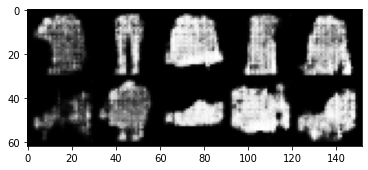

Epoch: 4 / 20
Discriminator Total Loss: 2.260, Discriminator Accuracy: 0.895, Generator Total Loss: 1.092


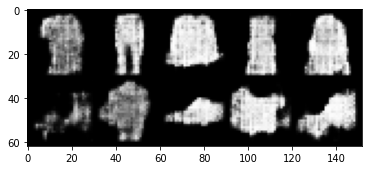

Epoch: 5 / 20
Discriminator Total Loss: 2.255, Discriminator Accuracy: 0.903, Generator Total Loss: 1.090


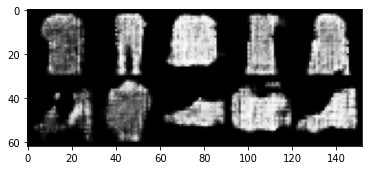

Epoch: 6 / 20
Discriminator Total Loss: 2.250, Discriminator Accuracy: 0.907, Generator Total Loss: 1.088


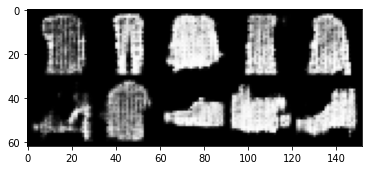

Epoch: 7 / 20
Discriminator Total Loss: 2.249, Discriminator Accuracy: 0.910, Generator Total Loss: 1.085


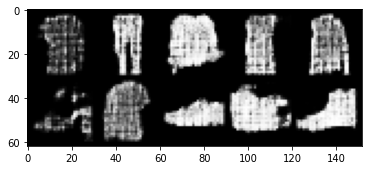

Epoch: 8 / 20
Discriminator Total Loss: 2.247, Discriminator Accuracy: 0.912, Generator Total Loss: 1.084


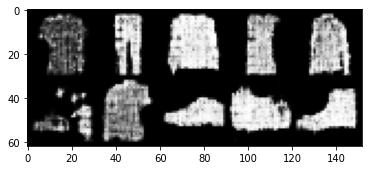

Epoch: 9 / 20
Discriminator Total Loss: 2.245, Discriminator Accuracy: 0.915, Generator Total Loss: 1.083


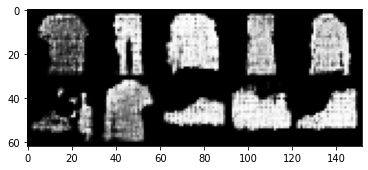

Epoch: 10 / 20
Discriminator Total Loss: 2.244, Discriminator Accuracy: 0.917, Generator Total Loss: 1.081


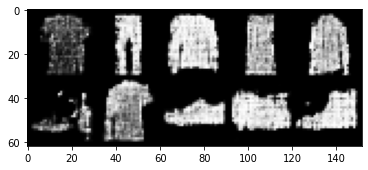

Epoch: 11 / 20
Discriminator Total Loss: 2.243, Discriminator Accuracy: 0.918, Generator Total Loss: 1.081


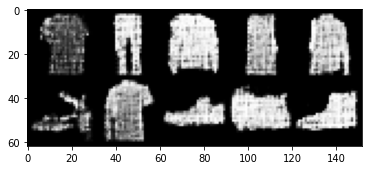

Epoch: 12 / 20
Discriminator Total Loss: 2.242, Discriminator Accuracy: 0.920, Generator Total Loss: 1.080


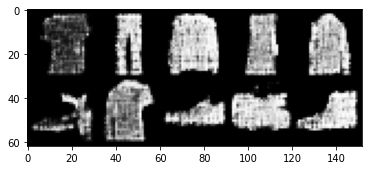

Epoch: 13 / 20
Discriminator Total Loss: 2.241, Discriminator Accuracy: 0.921, Generator Total Loss: 1.080


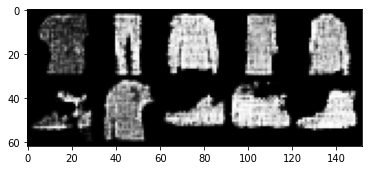

Epoch: 14 / 20
Discriminator Total Loss: 2.239, Discriminator Accuracy: 0.922, Generator Total Loss: 1.080


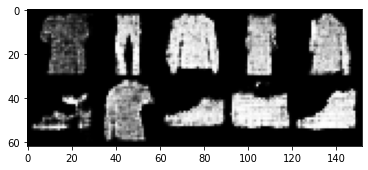

Epoch: 15 / 20
Discriminator Total Loss: 2.238, Discriminator Accuracy: 0.923, Generator Total Loss: 1.080


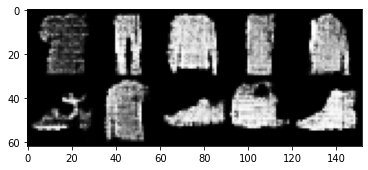

Epoch: 16 / 20
Discriminator Total Loss: 2.236, Discriminator Accuracy: 0.924, Generator Total Loss: 1.079


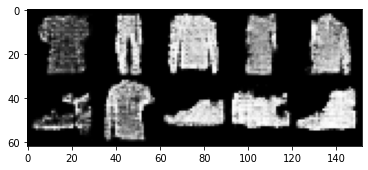

Epoch: 17 / 20
Discriminator Total Loss: 2.235, Discriminator Accuracy: 0.926, Generator Total Loss: 1.079


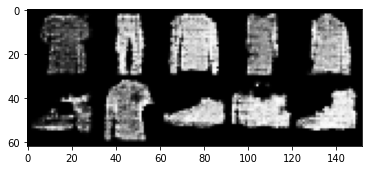

Epoch: 18 / 20
Discriminator Total Loss: 2.233, Discriminator Accuracy: 0.927, Generator Total Loss: 1.079


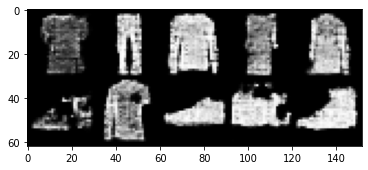

Epoch: 19 / 20
Discriminator Total Loss: 2.233, Discriminator Accuracy: 0.928, Generator Total Loss: 1.079


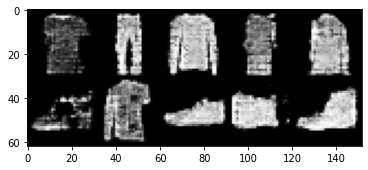

Epoch: 20 / 20
Discriminator Total Loss: 2.232, Discriminator Accuracy: 0.929, Generator Total Loss: 1.078


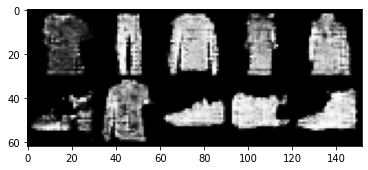

True

In [ ]:
# Set tdqm for epoch progress
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)
for epoch in range(params['epochs']):
  print(f'Epoch: {epoch + 1} / {params["epochs"]}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []
  accuracy_history = []

  for real_images, real_labels in datasetloader:

    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.cuda()

    # For real vs fake
    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    # Training Generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, params['noise_size'])).cuda()
    fake_labels = torch.randint(params['num_classes'], size=(current_batch_size, )).cuda()

    fake_images = generator(input_noise, fake_labels)

    ## Calculate Generator loss
    discriminator_fake_validity, discriminator_fake_labels = discriminator(fake_images)
    
    generator_total_loss = (adversarial_loss(discriminator_fake_validity, real_validity) + auxillary_loss(discriminator_fake_labels, fake_labels)) / 2
    generator_total_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_total_loss)

    # Training Discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_validity, discriminator_real_labels = discriminator(real_images)
    discriminator_real_loss = (adversarial_loss(discriminator_real_validity, real_validity) + auxillary_loss(discriminator_real_labels, real_labels)) / 2

    ## Loss for fake images
    discriminator_fake_validity, discriminator_fake_labels = discriminator(fake_images.detach())
    discriminator_fake_loss = (adversarial_loss(discriminator_fake_validity, fake_validity) + auxillary_loss(discriminator_fake_labels, fake_labels)) / 2

    ## Total loss
    discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
    discriminator_total_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_total_loss)

    # Calculate Discriminator Accuracy
    predictions = np.concatenate([discriminator_real_labels.data.cpu().numpy(), discriminator_fake_labels.data.cpu().numpy()], axis=0)
    true_values = np.concatenate([real_labels.cpu().numpy(), fake_labels.cpu().numpy()], axis=0)
    discriminator_accuracy = np.mean(np.argmax(predictions, axis=1) == true_values)
    accuracy_history.append(discriminator_accuracy)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Discriminator Accuracy: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          np.mean(accuracy_history), 
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))

  wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_total_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_total_losses)), 'batch wise accuracy': np.mean(accuracy_history)}, step=epoch+1)
  if (epoch + 1) % params['output_after_every_n_epochs'] == 0:
    plot_output(epoch + 1)

pbar.refresh()



In [ ]:
label_map = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
    3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
    7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

In [ ]:
generator.eval()
discriminator.eval()  
torch.save(generator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_CGANS/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_CGANS/discriminator.pt')
generator.train()
discriminator.train()  

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (discrim): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (aux): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

# Output

T-shirt/top


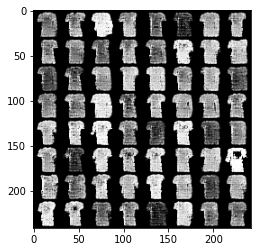

Trouser


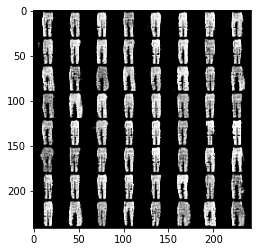

Pullover


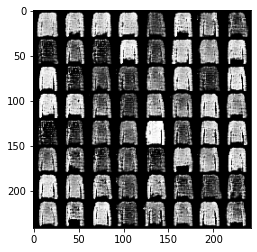

Dress


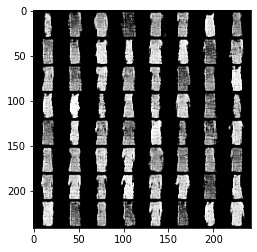

Coat


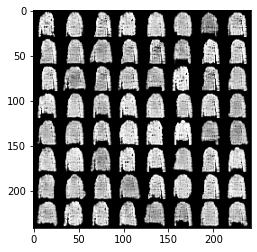

Sandal


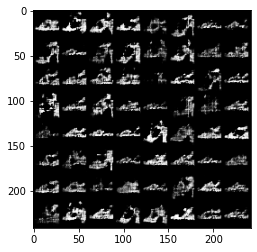

Shirt


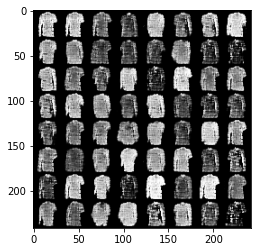

Sneaker


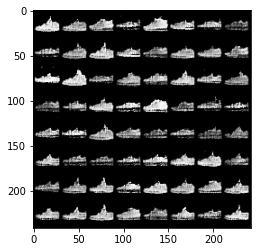

Bag


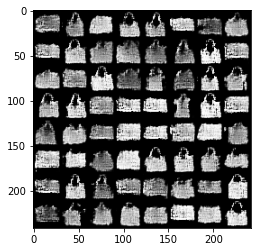

Ankle boot


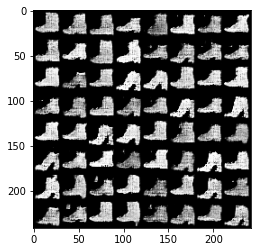

In [ ]:
images = []
with torch.no_grad():
  generator.eval()
  for num in range(10):
    input_noise = torch.randn(size=(params['batch_size'], params['noise_size'])).cuda()
    input_labels = torch.tensor([num for _ in range(params['batch_size'])]).cuda()

    output = generator(input_noise, input_labels)

    print(label_map[num])
    grid = torchvision.utils.make_grid(output.cpu(), normalize=True)
    show_grid(grid)
    images.append(transforms.ToPILImage()(grid))
    wandb.log({'result': wandb.Image(grid, caption=f'Output for class: {label_map[num]}')})

In [ ]:
# Save gif of output
images[0].save('fashionmnist-acgan.gif', save_all=True, append_images=images[1:])